In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpattern)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

source("functions/plot_scatterplot_with_density_snr_value.R")

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpattern

Loading required namespace: memoise

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: pbapply

Loading required package: ggforce



In [2]:
nthreads=10

In [3]:
dots_data0 = readRDS(file.path("/mnt/data/Imaging/202105-Deconwolf/data_210726",
                              "dots_data.rds"))[is.finite(SNR2) & SNR2 > 0 & Value2 > 0]
nuclear_features = fread("../data/selected_nuclei.tsv", key=c("sid", "nid"))

In [4]:
dots_data = rbindlist(pblapply(split(dots_data0, list(dots_data0$image_type, dots_data0$magnification)), function(subdata, nuclear_features) {
    setkeyv(subdata, c("series_id", "nid"))
    return(nuclear_features[subdata][!is.na(size)])
}, nuclear_features))
setnames(dots_data, "sid", "series_id")

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  


# Panel X2.a
Scatterplot of Value (Y) and SNR (X) for 20x.raw, cleaned, field 5. Density of Value on the side of Y panel.

In [5]:
cleaned_data = fread("../data/magnifications_matching/20x_raw.field_thr.cleaned.all.tsv")
setnames(cleaned_data, "sid", "series_id")

In [6]:
thr_table = fread("../data/magnifications_matching/intensity_thresholds.by_field.tsv")[image_type == "raw"]

In [7]:
dots_data2 = dots_data[is.finite(SNR2) & SNR2 > 0 & Value2 > 0][magnification == "20x" & image_type == "raw"][FWHM >= .5 & FWHM <= 5]

In [8]:
previously_filtered_dots = rbindlist(by(dots_data2, dots_data2$series_id, function(field_data, thr_data) {
    field_id = field_data[1, series_id]
    threshold = thr_data[sid == field_id, thr]
    field_data[Value2 < threshold]
}, thr_table))

In [9]:
pdata = rbindlist(list(
    previously_filtered_dots[, .(series_id, nid, magnification, image_type, FWHM, SNR2, Value2, dot_type="noisy")],
    cleaned_data[,             .(series_id, nid, magnification, image_type, FWHM, SNR2, Value2, dot_type="good")]
))

Warning message:
“Removed 93 rows containing non-finite values (stat_density).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 93 rows containing non-finite values (stat_density).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 93 rows containing missing values (geom_point).”


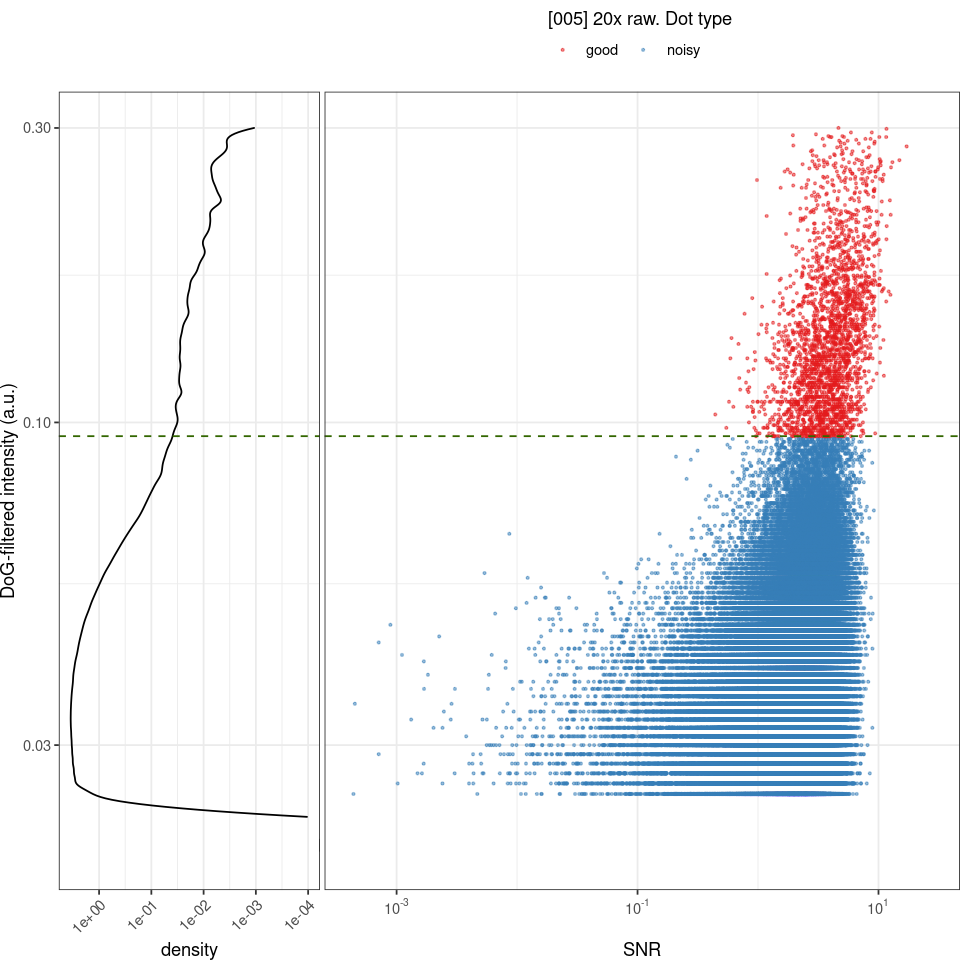

In [10]:
p = plot_scatterplot_with_density_snr_value(pdata[series_id == 5], nuclear_features, "20x", "raw", 5, .095, c(-3, -1, 1), c(.02, .3))
print(p)

In [11]:
ggsave(plot=p, file="panels/supp_fig_x3a.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x3a.rds")

# Panel X3.b
FWHM distribution of dots un/filtered by field-based threshold for 20x raw, clean, field 5.

In [12]:
cleaned_data = fread("../data/magnifications_matching/20x_raw.field_thr.cleaned.all.tsv")
setnames(cleaned_data, "sid", "series_id")

In [13]:
thr_table = fread("../data/magnifications_matching/intensity_thresholds.by_field.tsv")[image_type == "raw"]

In [14]:
dots_data2 = dots_data[is.finite(SNR2) & SNR2 > 0 & Value2 > 0][magnification == "20x" & image_type == "raw"][FWHM >= .5 & FWHM <= 5]

In [15]:
previously_filtered_dots = rbindlist(by(dots_data2, dots_data2$series_id, function(field_data, thr_data) {
    field_id = field_data[1, series_id]
    threshold = thr_data[sid == field_id, thr]
    field_data[Value2 < threshold]
}, thr_table))

In [16]:
clean_data = rbindlist(list(
    previously_filtered_dots[, .(series_id, nid, magnification, image_type="clean", FWHM, SNR2, Value2, dot_type="noisy")],
    cleaned_data[,             .(series_id, nid, magnification, image_type="clean", FWHM, SNR2, Value2, dot_type="good")]
))

In [17]:
# Apply threshold
raw_data = rbindlist(by(dots_data2, dots_data2$series_id, function(sdata) {
    sdata = copy(sdata)
    current_field_id = sdata[1, series_id]
    raw_thr = thr_table[image_type == "raw" & sid == current_field_id, thr]
    sdata[, dot_type := "noisy"]
    sdata["raw" == image_type & raw_thr <= Value2, dot_type := "good"]
    return(sdata)
}))[, .(series_id, nid, magnification, image_type, FWHM, SNR2, Value2, dot_type)]

In [18]:
pdata = rbindlist(list(clean_data, raw_data))

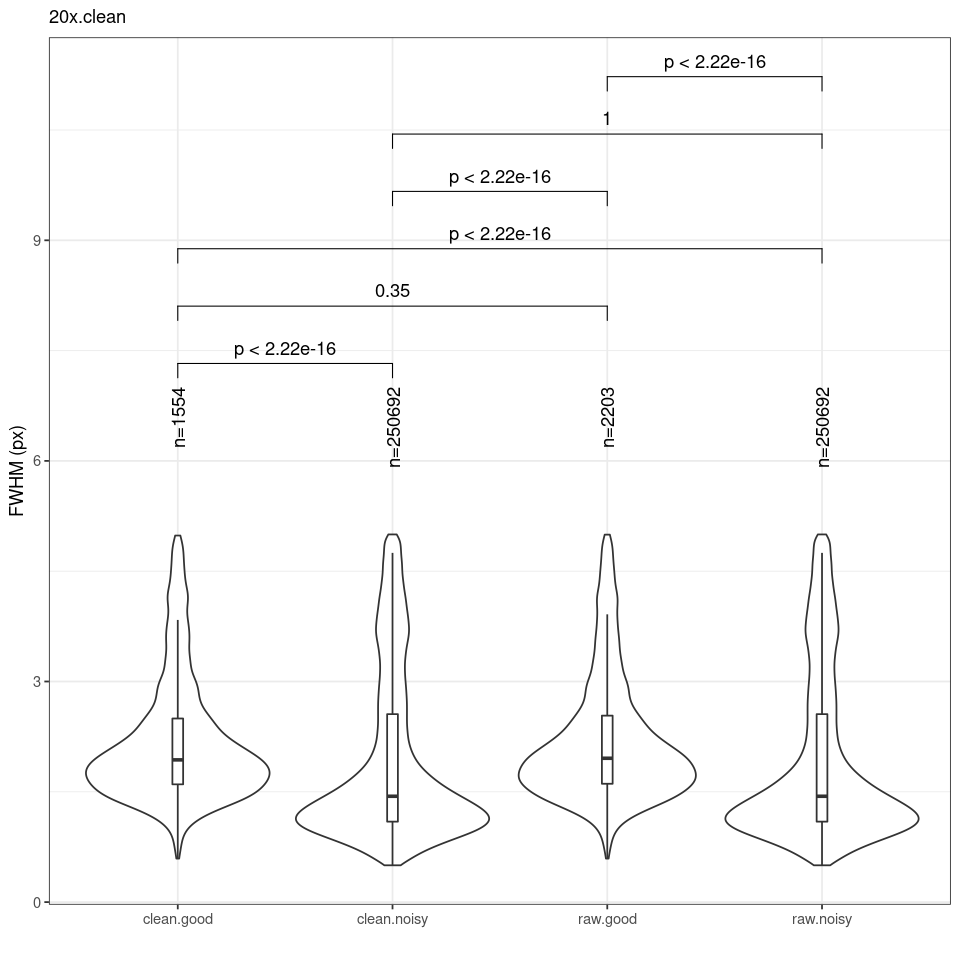

In [19]:
p = ggplot(pdata[5 == series_id], aes(x=paste0(image_type, ".", dot_type), y=FWHM)) +
    geom_violin(trim=T) + geom_boxplot(width=.05, outlier.shape=NA) +
    theme_bw() + labs(x="", y="FWHM (px)", subtitle="20x.clean") +
    theme(legend.position="bottom") +
    stat_compare_means(method="wilcox.test", comparisons=combn(4, 2, simplify=F)) +
    geom_text(data=pdata[1 == series_id][, .N, by=c("image_type", "dot_type")],
              aes(y=7, label=paste0("n=", N)), angle=90, hjust=1, vjust=.5)
p

In [20]:
ggsave(plot=p, file="panels/supp_fig_x3b.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x3b.rds")

# Panel X3.c
Column-plot with dot overlap between 20x.raw (clean) and 60x-based reference, all fields.

In [21]:
counts_raw = fread("../data/magnifications_matching/20x_raw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x"))[series_id <= 5]
counts_raw[, image_type := "raw"]

In [22]:
counts_raw_clean = fread("../data/magnifications_matching/20x_raw.matched_dots.field_thr.counts.clean.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x")
              )[series_id <= 5]
counts_raw_clean[, image_type := "raw"]

In [23]:
counts_dw = fread("../data/magnifications_matching/20x_dw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x"))[series_id <= 5]
counts_dw[, image_type := "dw"]

In [24]:
pdata = rbindlist(list(
    counts_raw[, .(series_id, dataset="raw", matched=matched/total_20x)],
    counts_dw[, .(series_id, dataset="dw", matched=matched/total_20x)],
    counts_raw_clean[, .(series_id, dataset="clean", matched=matched/total_20x)]
))
pdata[, unmatched := 1-matched]
pppdata = melt(pdata, id.vars=c("series_id", "dataset"))
pppdata$variable = factor(pppdata$variable, levels=c("unmatched", "matched"))
pppdata[, dataset_dotType := paste0(dataset, " - ", variable)]
pppdata$dataset = factor(pppdata$dataset, levels=c("raw", "dw", "clean"))
pppdata$dataset_dotType = factor(
    pppdata$dataset_dotType, levels=c(
        "raw - unmatched", "raw - matched",
        "dw - unmatched", "dw - matched",
        "clean - unmatched", "clean - matched"
    ))

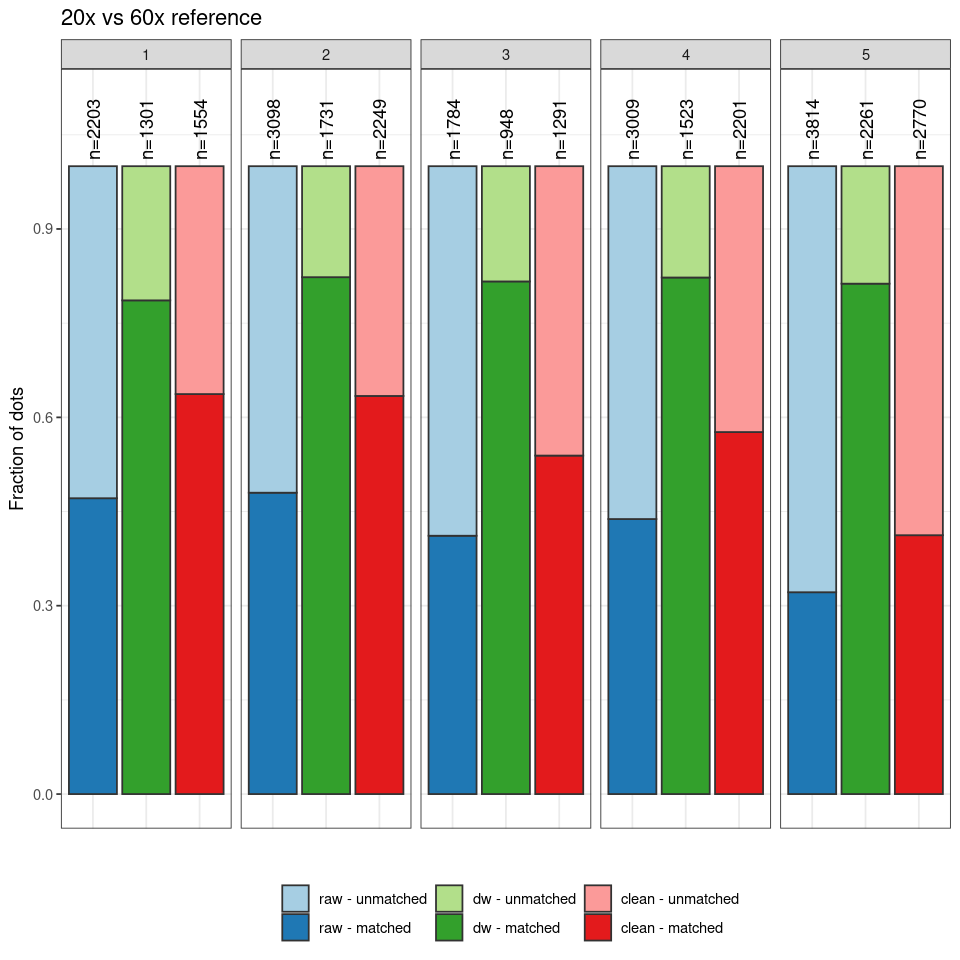

In [25]:
p = ggplot(pppdata, aes(x=dataset, y=value)) +
    geom_col(aes(fill=dataset_dotType), color="#323232") +
    facet_wrap(~series_id, nrow=1) +
    theme_bw() + theme(legend.position="bottom", axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    scale_fill_brewer("",  palette="Paired") + scale_pattern_color_grey() +
    labs(x="", y="Fraction of dots", title="20x vs 60x reference") +
    geom_text(data=counts_raw, aes(x="raw", y=1.01, label=paste0("n=", total_20x)), angle=90, hjust=0, vjust=.5) +
    geom_text(data=counts_dw, aes(x="dw", y=1.01, label=paste0("n=", total_20x)), angle=90, hjust=0, vjust=.5) +
    geom_text(data=counts_raw_clean, aes(x="clean", y=1.01, label=paste0("n=", total_20x)), angle=90, hjust=0, vjust=.5) +
    coord_cartesian(ylim=c(0, 1.1)) + guides(fill=guide_legend(nrow=2))
print(p)

In [26]:
ggsave(plot=p, file="panels/supp_fig_x3c.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x3c.rds")

# Panel X3.d
Column-plot with dot overlap between 20x.raw (clean) and 60x-based reference, all fields.

In [27]:
counts_raw = fread("../data/magnifications_matching/20x_raw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x"))[series_id <= 5]
counts_raw[, image_type := "raw"]

In [28]:
counts_raw_clean = fread("../data/magnifications_matching/20x_raw.matched_dots.field_thr.counts.clean.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x")
              )[series_id <= 5]
counts_raw_clean[, image_type := "raw"]

In [29]:
counts_dw = fread("../data/magnifications_matching/20x_dw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x"))[series_id <= 5]
counts_dw[, image_type := "dw"]

In [30]:
pdata = rbindlist(list(
    counts_raw[, .(series_id, dataset="raw", matched=matched/total_60x)],
    counts_dw[, .(series_id, dataset="dw", matched=matched/total_60x)],
    counts_raw_clean[, .(series_id, dataset="clean", matched=matched/total_60x)]
))
pdata[, unmatched := 1-matched]
pppdata = melt(pdata, id.vars=c("series_id", "dataset"))
pppdata$variable = factor(pppdata$variable, levels=c("unmatched", "matched"))
pppdata[, dataset_dotType := paste0(variable, " with 20x.", dataset )]
pppdata$dataset = factor(pppdata$dataset, levels=c("raw", "dw", "clean"))
pppdata$dataset_dotType = factor(
    pppdata$dataset_dotType, levels=c(
        "unmatched with 20x.raw", "matched with 20x.raw",
        "unmatched with 20x.dw", "matched with 20x.dw",
        "unmatched with 20x.clean", "matched with 20x.clean"
    ))

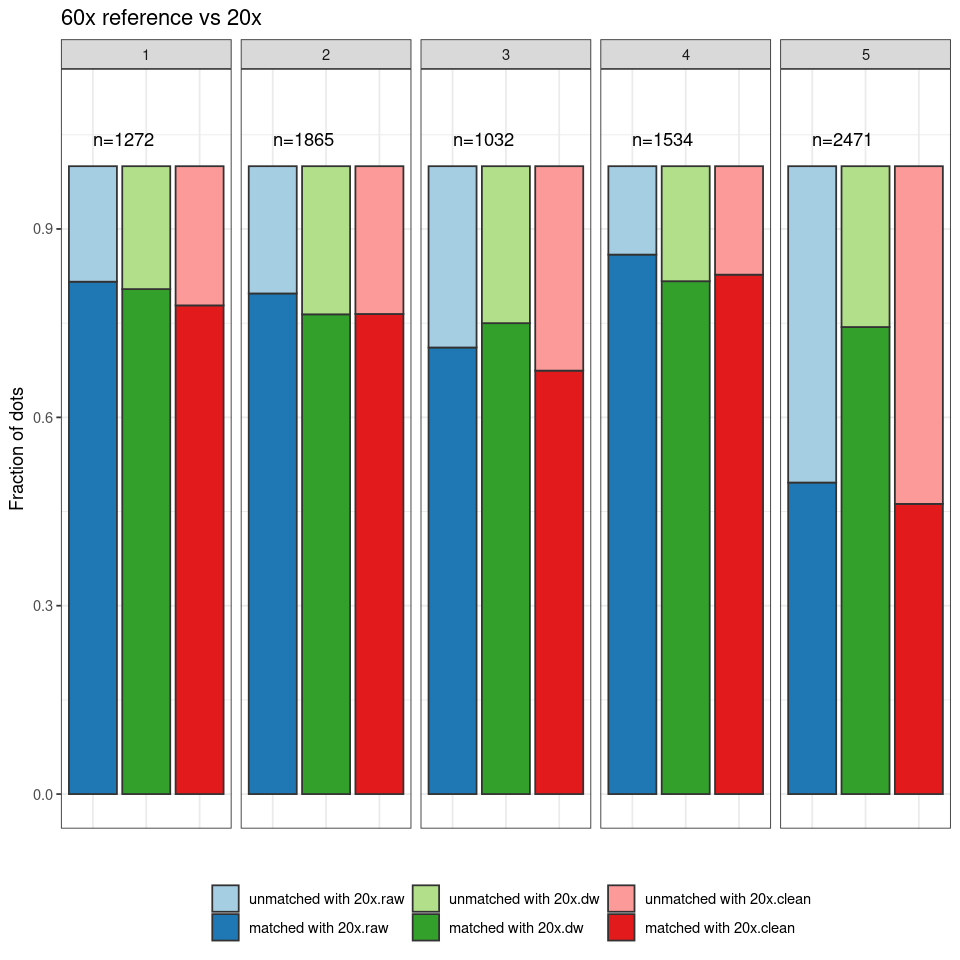

In [31]:
p = ggplot(pppdata, aes(x=dataset, y=value)) +
    geom_col(aes(fill=dataset_dotType), color="#323232") +
    facet_wrap(~series_id, nrow=1) +
    theme_bw() + theme(legend.position="bottom", axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
    scale_fill_brewer("",  palette="Paired") + scale_pattern_color_grey() +
    labs(x="", y="Fraction of dots", title="60x reference vs 20x") +
    geom_text(data=counts_raw, aes(x="raw", y=1.01, label=paste0("n=", total_60x)), vjust=-1, hjust=0) +
    coord_cartesian(ylim=c(0, 1.1)) + guides(fill=guide_legend(nrow=2))
print(p)

In [32]:
ggsave(plot=p, file="panels/supp_fig_x3d.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x3d.rds")